In [1]:
%pylab inline
%install_ext https://raw.github.com/cjdrake/ipython-magic/master/gvmagic.py
%load_ext gvmagic

import tensorflow as tf
sess = tf.InteractiveSession()
def myshow(image, label=None):
  image = image/1.0
  image = image - amin(image)
  image /= amax(image)
  axis('off')
  if label:
    title(label)
  imshow(image)

Populating the interactive namespace from numpy and matplotlib
Installed gvmagic.py. To use it, type:
  %load_ext gvmagic


/usr/local/google/home/keveman/jupyter/local/lib/python2.7/site-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension as a python package.
  "as a python package.", UserWarning)


### Image Classification Using TensorFlow

* Task : Classify 32x32 RGB images across 10 categories
  - `airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck`

* Data available at [http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz](http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz)

In [2]:
!ls -l data/cifar-10-batches-bin/*_1.bin

-rw-r----- 1 keveman eng 30730000 Feb 24 07:10 data/cifar-10-batches-bin/data_batch_1.bin


* Each file is 10000 images, each 32 * 32 RGB, plus one byte for label
  - $(32 \times 32 \times 3 \times 1) \times 10000 = 30730000 \ bytes$

* Read the data

In [3]:
data = []
for i in range(1, 6):
  with open(
    'data/cifar-10-batches-bin/data_batch_%d.bin' % i, 'rb') as batch:
    data.append(batch.read())
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog',
               'frog', 'horse', 'ship', 'truck']

* Decode the raw bytes and create a mini-batch of Tensors

In [4]:
def get_mini_batch(bytes, batch_size):
  img_size = 32 * 32 * 3
  # One 'record' is an image and a label
  record_size = img_size + 1
  images = []
  labels = []
  for i in range(batch_size):
    offset = i * record_size
    # Slice off a record and decode it in to a Tensor of type uint8
    decoded = tf.decode_raw(bytes[offset:offset + record_size], tf.uint8)
    # Slice off the label
    label =  tf.cast(decoded[0:1], tf.int32)
    # Slice off the image and reshape to 3-D
    image = tf.reshape(decoded[1:1+img_size], [3, 32, 32])
    # Reformat from [color, x, y] to [x, y, color]
    image = tf.transpose(image, [1, 2, 0])
    images.append(image)
    labels.append(label)
  return images, labels

* Let's look at the images

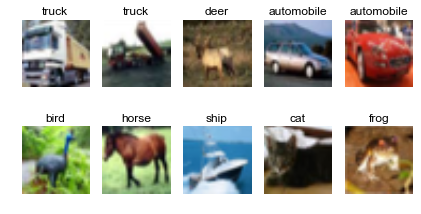

In [5]:
images, labels =  get_mini_batch(data[0], 10)
fig = figure(figsize = (7, 3.5))
for i in range(10):
  image, label = images[i], labels[i]
  subplot(2, 5, i)
  myshow(image.eval(), label_names[label.eval()[0]])

* Let's augment the data set
  - Extract a random 24 x 24 crop
  - Random flip left-to-right
  - Random brightness/contrast
  - Whiten the image (subtract mean, divide by variance)

In [6]:
def distort(image):
  image = tf.random_crop(image, [24, 24, 3])
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=63./255.)
  image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
  # This converts the image to floating point values
  image = tf.image.per_image_whitening(image)
  return image


* Let's look at the images again

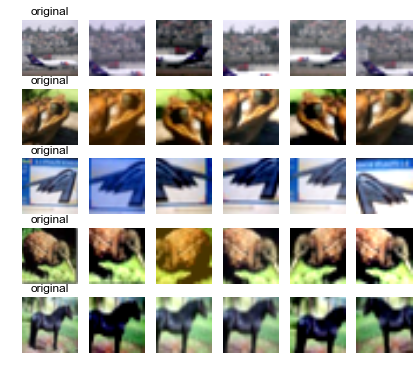

In [7]:
images, _ =  get_mini_batch(data[3], 5)
figsize(7, 6)
for i in range(5):
  subplot(5, 6, i*6+1)
  myshow(images[i].eval(), 'original')
  for j in range(5):
    subplot(5, 6, i*6+j+2)
    myshow(distort(images[i]).eval())


* Let's build a deep convolutional neural network to classify these images

In [8]:
cifar_model = """
digraph G {
  size="10!";
  rankdir=LR;
  node [shape=box, style="filled, rounded", fillcolor="#deebf7"];
  image -> conv1 -> pool1 -> norm1 -> conv2 -> norm2 -> pool2 -> local3 -> local4 -> softmax;
}
"""

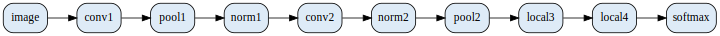

In [9]:
%dotstr cifar_model

* **conv** - Convolution with Relu activation
* **pool** - Max pooling
* **norm** - Local response normalization
* **local** - Fully connected layer

* Declare the model parameters (variables in TensorFlow parlance)

In [10]:
vars = {}

* **conv1**
  - `5x5` convolution
  - `3` input channels (RGB)
  - `64` output channels
  - Shape of the variable tensor is `[5, 5, 3, 64]`

In [11]:
vars['conv1_weights'] = tf.get_variable('conv1_weights',
                                        shape=[5, 5, 3, 64],
                                        initializer=tf.truncated_normal_initializer(stddev=1e-4))
vars['conv1_biases'] = tf.get_variable('conv1_biases',
                                       shape=[64],
                                       initializer=tf.constant_initializer(0.0))

In [12]:
def conv1(input):
  output = tf.nn.conv2d(
    input,
    vars['conv1_weights'],
    [1, 1, 1, 1], # strides
    padding='SAME')
  output = output + vars['conv1_biases']
  return tf.nn.relu(output)

In [13]:
def pool1(input):
  return tf.nn.max_pool(input, ksize=[1, 3, 3, 1],
                        strides=[1, 2, 2, 1],
                        padding='SAME')

In [14]:
def norm1(input):
  return tf.nn.lrn(input, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)

In [15]:
vars['conv2_weights'] = tf.get_variable('conv2_weights',
                                        shape=[5, 5, 64, 64],
                                        initializer=tf.truncated_normal_initializer(stddev=1e-4))
vars['conv2_biases'] = tf.get_variable('conv2_biases',
                                       shape=[64],
                                       initializer=tf.constant_initializer(0.1))
def conv2(input):
  output = tf.nn.conv2d(
    input,
    vars['conv2_weights'],
    [1, 1, 1, 1], # strides
    padding='SAME')
  output = output + vars['conv2_biases']
  return tf.nn.relu(output)

def norm2(input):
  return tf.nn.lrn(input, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)

def pool2(input):
  return tf.nn.max_pool(input, ksize=[1, 3, 3, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

* Everything in working order?

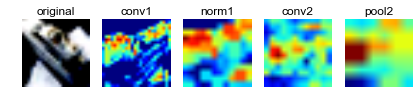

In [16]:
im, _ = get_mini_batch(data[2], 1)
im = distort(im[0])
subplot(1, 5, 1)
myshow(im.eval(), 'original')

im = tf.expand_dims(im, 0)
tf.initialize_all_variables().run()

x = conv1(im).eval(); subplot(1, 5, 2); myshow(x[0, :, :, 0], 'conv1')
x = norm1(pool1(x)).eval(); subplot(1, 5, 3); myshow(x[0, :, :, 0], 'norm1')
x = conv2(x).eval(); subplot(1, 5, 4); myshow(x[0, :, :, 0], 'conv2')
x = pool2(norm2(x)).eval(); subplot(1, 5, 5); myshow(x[0, :, :, 0], 'pool2')

* **local3**
  - Fully connected layer
  - **pool2** output's shape is `[6, 6, 64]`
  - We'll make **local3** produce `384` features
  - `[6 * 6 * 64, 384]` weight matrix and `[384]` bias vector

In [17]:
vars['local3_weights'] = tf.get_variable('local3_weights',
                                        shape=[6*6*64, 384],
                                        initializer=tf.truncated_normal_initializer(stddev=0.04))
vars['local3_biases'] = tf.get_variable('local3_biases',
                                       shape=[384],
                                       initializer=tf.constant_initializer(0.1))
def local3(input):
  output = tf.matmul(input, vars['local3_weights'])
  output = output + vars['local3_biases']
  return tf.nn.relu(output)

* ** local4**
  - `[384, 192]` weight matrix, `[192]` bias vector

In [18]:
vars['local4_weights'] = tf.get_variable('local4_weights',
                                        shape=[384, 192],
                                        initializer=tf.truncated_normal_initializer(stddev=0.04))
vars['local4_biases'] = tf.get_variable('local4_biases',
                                       shape=[192],
                                       initializer=tf.constant_initializer(0.1))
def local4(input):
  output = tf.matmul(input, vars['local4_weights'])
  output = output + vars['local4_biases']
  return tf.nn.relu(output)

* **softmax_linear**
  - Compute logits to feed into the softmax function
  - `[192, 10]` weight matrix, because we have `10` classes
  - `[10]` bias vector

In [19]:
vars['sm_weights'] = tf.get_variable('sm_weights',
                                    shape=[192, 10],
                                    initializer=tf.truncated_normal_initializer(stddev=1/192.0))
vars['sm_biases'] = tf.get_variable('sm_biases',
                                   shape=[10],
                                   initializer=tf.constant_initializer(0.0))
def softmax_linear(input):
  output = tf.matmul(input, vars['sm_weights'])
  output = output + vars['sm_biases']
  return output

* Everything in working order?
  - Ask the model to predict the class of an image
  - (Hopefully) It should give us uniform predictions

In [26]:
im, _ = get_mini_batch(data[2], 1)
im = distort(im[0])
im = tf.expand_dims(im, 0)
tf.initialize_all_variables().run()
x = pool2(norm2(conv2(norm1(pool1(conv1(im))))))
x = tf.reshape(x, [1, 6*6*64])
x = tf.nn.softmax(softmax_linear(local4(local3(x))))
print(x.eval())

[[ 0.10053313  0.10056192  0.09846767  0.10175371  0.09997072  0.0989769
   0.1000073   0.10003264  0.10038149  0.09931451]]
